<a href="https://colab.research.google.com/github/Farhana-Najnin/Retail-Demand-Forecaster/blob/main/Retail_Demand_Forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#BLOCK 1 — Install & upgrade libraries (IMPORTANT)
pip install -q -U datasets huggingface_hub pandas numpy matplotlib scikit-learn prophet


In [2]:
#BLOCK 2 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.metrics import mean_absolute_error


In [3]:
#BLOCK 3 — Load the WORKING dataset
ds = load_dataset("t4tiana/store-sales-time-series-forecasting")
print(ds)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.csv:   0%|          | 0.00/122M [00:00<?, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'],
        num_rows: 3000888
    })
    test: Dataset({
        features: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'],
        num_rows: 28512
    })
})


In [4]:
#BLOCK 4 — Load train split safely
df = ds["train"].to_pandas()

print(df.shape)
print(df.columns)
df.head()


(3000888, 6)
Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
#BLOCK 5 — Clean & standardize columns
df["date"] = pd.to_datetime(df["date"])

df = df.rename(columns={
    "store_nbr": "store_id",
    "family": "item_id",
    "sales": "y"
})

df["series_id"] = df["store_id"].astype(str) + "_" + df["item_id"].astype(str)

df = df.sort_values(["series_id", "date"]).reset_index(drop=True)

df.head()


,id,date,store_id,item_id,y,onpromotion,series_id
0,33,2013-01-01,10,AUTOMOTIVE,0.0,0,10_AUTOMOTIVE
1,1815,2013-01-02,10,AUTOMOTIVE,3.0,0,10_AUTOMOTIVE
2,3597,2013-01-03,10,AUTOMOTIVE,2.0,0,10_AUTOMOTIVE
3,5379,2013-01-04,10,AUTOMOTIVE,2.0,0,10_AUTOMOTIVE
4,7161,2013-01-05,10,AUTOMOTIVE,0.0,0,10_AUTOMOTIVE


In [6]:
#BLOCK 6 — Create time index
df["t"] = df.groupby("series_id").cumcount()
df[["series_id", "date", "t", "y"]].head()


,series_id,date,t,y
0,10_AUTOMOTIVE,2013-01-01,0,0.0
1,10_AUTOMOTIVE,2013-01-02,1,3.0
2,10_AUTOMOTIVE,2013-01-03,2,2.0
3,10_AUTOMOTIVE,2013-01-04,3,2.0
4,10_AUTOMOTIVE,2013-01-05,4,0.0


In [7]:
#BLOCK 7 — Train / validation split (last 28 days per series)
H = 28

train_rows = []
val_rows = []

for sid, g in df.groupby("series_id"):
    if len(g) <= H:
        continue
    train_rows.append(g.iloc[:-H])
    val_rows.append(g.iloc[-H:])

train_df = pd.concat(train_rows)
val_df   = pd.concat(val_rows)

print(train_df.shape, val_df.shape)


(2950992, 8) (49896, 8)


In [8]:
#PART 1 — Prophet with Uncertainty (P50 / P90)
# BLOCK 8 — Prophet forecasting function
from prophet import Prophet

def prophet_with_uncertainty(train_df, val_df, max_series=50):
    outputs = []
    series_list = train_df["series_id"].unique()[:max_series]

    for sid in series_list:
        tr = train_df[train_df["series_id"] == sid]
        va = val_df[val_df["series_id"] == sid]

        m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
        m.fit(tr.rename(columns={"date": "ds"})[["ds", "y"]])

        future = va.rename(columns={"date": "ds"})[["ds"]]
        fcst = m.predict(future)

        outputs.append(pd.DataFrame({
            "series_id": sid,
            "y_true": va["y"].values,
            "p50": np.clip(fcst["yhat"].values, 0, None),
            "p90": np.clip(fcst["yhat_upper"].values, 0, None),
        }))

    return pd.concat(outputs, ignore_index=True)


In [9]:
#BLOCK 9 — Run Prophet + check accuracy
prophet_val = prophet_with_uncertainty(train_df, val_df, max_series=50)

print("MAE (P50):",
      mean_absolute_error(prophet_val["y_true"], prophet_val["p50"]))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE (P50): 88.37301024650074


In [10]:
#PART 2 — Inventory & Cost Simulation (THE REAL VALUE)
# BLOCK 10 — Inventory simulation function
def simulate_inventory_costs(
    demand,
    forecast,
    lead_time=7,
    holding_cost=1.0,
    stockout_cost=10.0
):
    inventory = 0.0
    pipeline = [0.0] * lead_time

    holding_total = 0.0
    stockout_total = 0.0
    stockout_events = 0

    for d, f in zip(demand, forecast):
        inventory += pipeline.pop(0)

        if d > inventory:
            unmet = d - inventory
            stockout_total += unmet * stockout_cost
            inventory = 0
            stockout_events += 1
        else:
            inventory -= d

        holding_total += inventory * holding_cost

        target = lead_time * f
        order_qty = max(target - (inventory + sum(pipeline)), 0)
        pipeline.append(order_qty)

    return {
        "total_cost": holding_total + stockout_total,
        "holding_cost": holding_total,
        "stockout_cost": stockout_total,
        "stockout_events": stockout_events
    }


In [11]:
#BLOCK 11 — Compare P50 vs P90 (SERVICE LEVEL LOGIC)
res_p50 = simulate_inventory_costs(
    prophet_val["y_true"].values,
    prophet_val["p50"].values
)

res_p90 = simulate_inventory_costs(
    prophet_val["y_true"].values,
    prophet_val["p90"].values
)

res_p50, res_p90


({'total_cost': np.float64(15852700.465022732),
  'holding_cost': np.float64(14227544.085982105),
  'stockout_cost': np.float64(1625156.3790406268),
  'stockout_events': 128},
 {'total_cost': np.float64(20368676.187157787),
  'holding_cost': np.float64(19315855.008506),
  'stockout_cost': np.float64(1052821.178651786),
  'stockout_events': 56})

In [12]:
#BLOCK 12 — Business impact summary
def print_summary(name, res):
    print(f"\n{name}")
    print("Total cost:     ", round(res["total_cost"], 2))
    print("Holding cost:   ", round(res["holding_cost"], 2))
    print("Stockout cost:  ", round(res["stockout_cost"], 2))
    print("Stockout events:", res["stockout_events"])

print_summary("Prophet P50", res_p50)
print_summary("Prophet P90 (Service-Level)", res_p90)

print("\nStockout reduction (%):",
      (res_p50["stockout_events"] - res_p90["stockout_events"])
      / max(res_p50["stockout_events"], 1) * 100)



Prophet P50
Total cost:      15852700.47
Holding cost:    14227544.09
Stockout cost:   1625156.38
Stockout events: 128

Prophet P90 (Service-Level)
Total cost:      20368676.19
Holding cost:    19315855.01
Stockout cost:   1052821.18
Stockout events: 56

Stockout reduction (%): 56.25


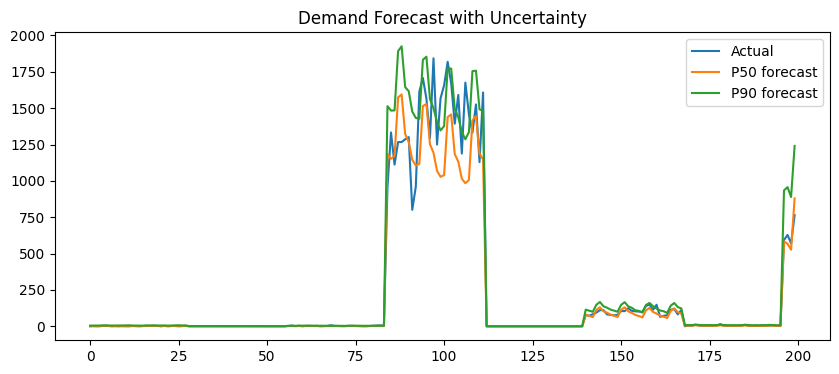

In [13]:
#BLOCK 13 — Visual sanity check (optional but recommended)
N = 200

plt.figure(figsize=(10,4))
plt.plot(prophet_val["y_true"].values[:N], label="Actual")
plt.plot(prophet_val["p50"].values[:N], label="P50 forecast")
plt.plot(prophet_val["p90"].values[:N], label="P90 forecast")
plt.legend()
plt.title("Demand Forecast with Uncertainty")
plt.show()
